In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder\
    .config("spark.executor.memory", '32g') \
    .config('spark.executor.cores', '2') \
    .config('spark.cores.max', '8') \
    .config("spark.driver.memory",'32g') \
    .config("spark.sql.broadcastTimeout", "1000") \
    .config("spark.driver.maxResultSize", '10g') \
    .getOrCreate()

sc = spark.sparkContext

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler
import pandas as pd
from PIL import Image
import numpy as np
import io
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
import os
import pyspark.sql.functions as F
from pyspark.mllib.linalg import Vectors


%matplotlib inline

In [3]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType
import re

In [4]:
data_dir = "/project/ds5559/BioNerds/ham"
os.chdir('/project/ds5559/BioNerds/ham')
ResNet50_Folder = "/project/ds5559/BioNerds/saved_data/ResNet50_testing/"
model_path = "Final_model"
model_dir = os.path.join(ResNet50_Folder,model_path)

# load pre-processed table

In [5]:
clean_df = spark.read.load("/project/ds5559/BioNerds/saved_data/clean_indexed.parquet").drop("path","features","features_2","ID")

In [6]:
clean_df.show(5)

+-----------+------------+---+---------+----+------+---------------+----------+-----------+-----------+------------+
|  lesion_id|    image_id| dx|  dx_type| age|   sex|   localization|indexed_dx|indexed_sex|indexed_loc|indexed_type|
+-----------+------------+---+---------+----+------+---------------+----------+-----------+-----------+------------+
|HAM_0006003|ISIC_0032827|bkl|consensus|85.0|female|lower extremity|       2.0|        1.0|        1.0|         2.0|
|HAM_0000772|ISIC_0032994| nv|    histo|20.0|female|           face|       0.0|        1.0|        5.0|         0.0|
|HAM_0002021|ISIC_0029466|bcc|    histo|65.0|female|upper extremity|       3.0|        1.0|        3.0|         0.0|
|HAM_0007502|ISIC_0030754|mel|    histo|50.0|female|lower extremity|       1.0|        1.0|        1.0|         0.0|
|HAM_0000966|ISIC_0030168| nv|follow_up|45.0|female|          trunk|       0.0|        1.0|        2.0|         1.0|
+-----------+------------+---+---------+----+------+------------

# Load images and transfer them with newly trained Tensorflow model

In [7]:
images1 = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load("/project/ds5559/BioNerds/ham/HAM10000_images_part_1")

In [8]:
images2 = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load("/project/ds5559/BioNerds/ham/HAM10000_images_part_2")

In [9]:
images1.show(2)

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/project/ds5...|2019-10-06 20:55:50|459172|[FF D8 FF DB 00 4...|
|file:/project/ds5...|2019-10-06 20:56:18|447988|[FF D8 FF DB 00 4...|
+--------------------+-------------------+------+--------------------+
only showing top 2 rows



# Image--> Vector transfer Functions

In [10]:
def model_fn():
  """
  Returns a New Transfer Learnning model with top layer removed and broadcasted pretrained weights.
  """
  model = tf.keras.models.load_model(model_dir)
  new_model = tf.keras.models.Sequential(model.layers[:-1])
  return new_model




In [11]:
def preprocess(content):
  """
  Preprocesses raw image bytes for prediction.
  """
  img = Image.open(io.BytesIO(content)).resize([224, 224])
  arr = img_to_array(img)
  return preprocess_input(arr)

def featurize_series(model, content_series):
  """
  Featurize a pd.Series of raw images using the input model.
  :return: a pd.Series of image features
  """
  input = np.stack(content_series.map(preprocess))
  preds = model.predict(input)
  # For some layers, output features will be multi-dimensional tensors.
  # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
  output = [p.flatten() for p in preds]
  return pd.Series(output)


In [12]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
  '''
  This method is a Scalar Iterator pandas UDF wrapping our featurization function.
  The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
  :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
  '''
  # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
  # for multiple data batches.  This amortizes the overhead of loading big models.
  model = model_fn()
  for content_series in content_series_iter:
    yield featurize_series(model, content_series)

/usr/local/spark/python/pyspark/sql/pandas/functions.py:386: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


In [13]:
# Pandas UDFs on large records (e.g., very large images) can run into Out Of Memory (OOM) errors.
# If you hit such errors in the cell below, try reducing the Arrow batch size via `maxRecordsPerBatch`.
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")
# We can now run featurization on our entire Spark DataFrame.
# NOTE: This can take a long time (about 10 minutes) since it applies a large model to the full dataset.
features_df1 = images1.repartition(16).select(col("path"), featurize_udf("content").alias("features"))
#features_df.write.mode("overwrite").parquet("dbfs:/ml/tmp/flower_photos_features")
features_df2 = images2.repartition(16).select(col("path"), featurize_udf("content").alias("features"))

In [14]:
print("number of pictures in folder 1: {}".format(features_df1.count()))
print("number of pictures in folder 2: {}".format(features_df2.count()))

number of pictures in folder 1: 5000
number of pictures in folder 2: 5015


In [15]:
print(features_df1.columns)
print(features_df2.columns)

['path', 'features']
['path', 'features']


In [16]:
features_df = features_df1.union(features_df2)
print("number of pictures in combined dataframe: {}".format(features_df.count()))

number of pictures in combined dataframe: 10015


In [17]:
features_df.cache()

DataFrame[path: string, features: array<float>]

In [18]:
features_df.show(1)

+--------------------+--------------------+
|                path|            features|
+--------------------+--------------------+
|file:/project/ds5...|[0.0, 0.0, 0.0, 0...|
+--------------------+--------------------+
only showing top 1 row



In [19]:
len(features_df.select("features").first()[0])

2048

#### class_from_path(col('path')))

In [20]:
pathToID = udf(lambda z: toClass(z), StringType())
spark.udf.register("pathToID", pathToID)
def toClass(s):
    p = re.compile("ISIC_[0-9]*")
    result = p.search(s)
    return(result.group(0))

features_df = features_df.withColumn('ID', pathToID('path')).drop("path")
features_df.show(5)

+--------------------+------------+
|            features|          ID|
+--------------------+------------+
|[0.0, 0.0, 0.0, 0...|ISIC_0026343|
|[0.0, 0.0, 0.2128...|ISIC_0027333|
|[0.0, 0.0, 0.0, 0...|ISIC_0026964|
|[0.0, 0.0, 0.0, 0...|ISIC_0028228|
|[0.27657363, 0.0,...|ISIC_0029303|
+--------------------+------------+
only showing top 5 rows



## joint new image features with indexed table

In [21]:
clean_df_new = clean_df.join(F.broadcast(features_df), clean_df.image_id == features_df.ID, 'left_outer')

In [22]:
%%time
clean_df_new.select('ID').count()

CPU times: user 49.8 ms, sys: 30.4 ms, total: 80.1 ms
Wall time: 12min 41s


9948

In [23]:
clean_df_new.cache()

DataFrame[lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, indexed_dx: double, indexed_sex: double, indexed_loc: double, indexed_type: double, features: array<float>, ID: string]

In [24]:
from pyspark.ml.linalg import Vectors, VectorUDT
to_vector = udf(lambda a: Vectors.dense(a), VectorUDT())

clean_df = clean_df_new.select("*", to_vector("features").alias("features_2"))

In [25]:
%%time
clean_df.show(5)
clean_df.cache()

+-----------+------------+---+---------+----+------+---------------+----------+-----------+-----------+------------+--------------------+------------+--------------------+
|  lesion_id|    image_id| dx|  dx_type| age|   sex|   localization|indexed_dx|indexed_sex|indexed_loc|indexed_type|            features|          ID|          features_2|
+-----------+------------+---+---------+----+------+---------------+----------+-----------+-----------+------------+--------------------+------------+--------------------+
|HAM_0006003|ISIC_0032827|bkl|consensus|85.0|female|lower extremity|       2.0|        1.0|        1.0|         2.0|[0.020838182, 0.0...|ISIC_0032827|[0.02083818241953...|
|HAM_0000772|ISIC_0032994| nv|    histo|20.0|female|           face|       0.0|        1.0|        5.0|         0.0|[0.12681174, 0.0,...|ISIC_0032994|[0.12681174278259...|
|HAM_0002021|ISIC_0029466|bcc|    histo|65.0|female|upper extremity|       3.0|        1.0|        3.0|         0.0|[0.0, 0.0, 0.0, 0...|ISI

DataFrame[lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, indexed_dx: double, indexed_sex: double, indexed_loc: double, indexed_type: double, features: array<float>, ID: string, features_2: vector]

#### assemble features 

In [26]:
from pyspark.ml.feature import OneHotEncoder


#Define preprocessing pipeline

#OneHot encode variables
OH = OneHotEncoder(inputCols = ['indexed_sex', 'indexed_loc'], outputCols = ['OH_sex', 'OH_loc'])

#Assemble Features vector
vec_assemb = VectorAssembler(inputCols = ['age', 'OH_sex', 'OH_loc', 'features_2'], \
                             outputCol = 'Feature_vec', handleInvalid = 'skip')

mlr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0,  family="multinomial", probabilityCol = 'probability')
mlr.setFeaturesCol("Feature_vec").setThreshold(0.5).setLabelCol("indexed_dx")

LogisticRegression_2594ead00f7f

In [27]:
%%time
#model_pipe = pipe.fit(clean_df)
model_pipe = Pipeline(stages = [ OH, vec_assemb, mlr])

CPU times: user 40 µs, sys: 336 µs, total: 376 µs
Wall time: 258 µs


#### save transformed TL model dataframe

In [28]:
clean_df.write.mode("overwrite").save("/project/ds5559/BioNerds/saved_data/ResNet50_indexed.parquet")

# split transformed_table to training set and test set by dx. 
# using stratified split by ratio 0.8:0.2

In [28]:
clean_df.select("dx", "indexed_dx").groupby("dx","indexed_dx").count().show()

+-----+----------+-----+
|   dx|indexed_dx|count|
+-----+----------+-----+
|  bcc|       3.0|  514|
|  mel|       1.0| 1111|
|   nv|       0.0| 6650|
|  bkl|       2.0| 1089|
|   df|       6.0|  115|
| vasc|       5.0|  142|
|akiec|       4.0|  327|
+-----+----------+-----+



In [29]:
fractions = clean_df.select("dx").distinct().withColumn("fraction", F.lit(0.8)).rdd.collectAsMap()
fractions

{'vasc': 0.8,
 'nv': 0.8,
 'mel': 0.8,
 'bcc': 0.8,
 'df': 0.8,
 'bkl': 0.8,
 'akiec': 0.8}

In [30]:
training_set = clean_df.stat.sampleBy("dx",fractions, seed=314)

In [31]:
%%time
training_set.select("dx", "indexed_dx").groupby("dx","indexed_dx").count().show()
training_set.cache()

+-----+----------+-----+
|   dx|indexed_dx|count|
+-----+----------+-----+
|  bcc|       3.0|  411|
|  mel|       1.0|  890|
|   nv|       0.0| 5336|
|  bkl|       2.0|  865|
|   df|       6.0|   95|
| vasc|       5.0|  111|
|akiec|       4.0|  272|
+-----+----------+-----+

CPU times: user 11.3 ms, sys: 8.29 ms, total: 19.6 ms
Wall time: 862 ms


DataFrame[lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, indexed_dx: double, indexed_sex: double, indexed_loc: double, indexed_type: double, features: array<float>, ID: string, features_2: vector]

In [32]:
%%time
test_set = clean_df.subtract(training_set)
test_set.cache()

CPU times: user 1.11 ms, sys: 1.09 ms, total: 2.2 ms
Wall time: 235 ms


DataFrame[lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, indexed_dx: double, indexed_sex: double, indexed_loc: double, indexed_type: double, features: array<float>, ID: string, features_2: vector]

In [33]:
%%time
test_set.select("dx", "indexed_dx").groupby("dx","indexed_dx").count().show()

+-----+----------+-----+
|   dx|indexed_dx|count|
+-----+----------+-----+
|  bcc|       3.0|  103|
|  mel|       1.0|  221|
|   nv|       0.0| 1314|
|  bkl|       2.0|  224|
|   df|       6.0|   20|
| vasc|       5.0|   31|
|akiec|       4.0|   55|
+-----+----------+-----+

CPU times: user 47 ms, sys: 15.4 ms, total: 62.4 ms
Wall time: 9.07 s


In [38]:
%%time
model_mlr = model_pipe.fit(training_set)

CPU times: user 39.9 ms, sys: 17.9 ms, total: 57.8 ms
Wall time: 4.75 s


In [39]:
%%time
predictions =model_mlr.transform(test_set)

CPU times: user 5.59 ms, sys: 5.71 ms, total: 11.3 ms
Wall time: 128 ms


In [40]:
%%time
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_dx")
evaluator.evaluate(predictions)

CPU times: user 10.3 ms, sys: 3.63 ms, total: 13.9 ms
Wall time: 669 ms


0.7988373178287209

In [41]:
from pyspark.mllib.evaluation import MulticlassMetrics
predictionAndLabels = predictions.select("prediction","indexed_dx")

#### confusion matrix

In [42]:
metrics = MulticlassMetrics(predictionAndLabels.rdd)
metrics.confusionMatrix().toArray()

array([[1.275e+03, 1.700e+01, 1.500e+01, 5.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00],
       [1.040e+02, 8.800e+01, 1.800e+01, 3.000e+00, 8.000e+00, 0.000e+00,
        0.000e+00],
       [5.500e+01, 1.900e+01, 1.470e+02, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00],
       [1.900e+01, 4.000e+00, 9.000e+00, 6.600e+01, 3.000e+00, 2.000e+00,
        0.000e+00],
       [9.000e+00, 6.000e+00, 1.100e+01, 8.000e+00, 2.100e+01, 0.000e+00,
        0.000e+00],
       [1.500e+01, 1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.100e+01,
        1.000e+00],
       [1.300e+01, 1.000e+00, 3.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00]])

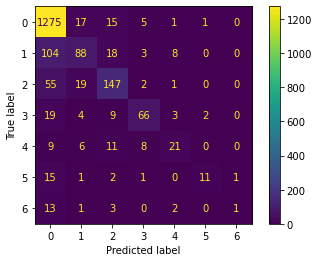

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
ConfusionMatrixDisplay(metrics.confusionMatrix().toArray().astype(int)).plot()

#### accuracy, precision, recall, fMeasure

In [44]:
print("accuracy: {}".format(metrics.accuracy))
print("precision: {}".format(metrics.weightedPrecision))
print("recall: {}".format(metrics.weightedRecall))
print("fMeasure: {}".format(metrics.weightedFMeasure()))

accuracy: 0.8175813008130082
precision: 0.8000189584232604
recall: 0.8175813008130081
fMeasure: 0.7988373178287209


### Statistics by class

In [45]:
labels = predictionAndLabels.rdd.map(lambda lp: lp.indexed_dx).distinct().collect()
df = pd.DataFrame()
for label in sorted(labels):
    df = df.append({"class": label, 
               "precision":metrics.precision(label),
               "recall":metrics.recall(label),
               "f1":metrics.fMeasure(label),
              }, ignore_index=True)
df

,class,f1,precision,recall
0,0.0,0.909415,0.855705,0.970320
1,1.0,0.492997,0.647059,0.398190
2,2.0,0.685315,0.717073,0.656250
3,3.0,0.702128,0.776471,0.640777
4,4.0,0.461538,0.583333,0.381818
5,5.0,0.488889,0.785714,0.354839
6,6.0,0.090909,0.500000,0.050000


# Cross validation

In [64]:
### cross valication

#%%time
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(mlr.regParam, [0, 0.1, 0.2, 0.3, 0.4, 0.5]) # regularization parameter
             .addGrid(mlr.elasticNetParam, [0.0, 0.1, 0.2, 0.3, 0.4]) # Elastic Net Parameter (Ridge = 0)
             .build())

In [65]:
%%time
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=model_pipe, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5, \
                    parallelism = 4,
                    seed = 314)

CPU times: user 673 µs, sys: 0 ns, total: 673 µs
Wall time: 650 µs


In [66]:
%%time
cvModel = cv.fit(training_set)

cv_predictions = cvModel.transform(test_set)

CPU times: user 10.4 s, sys: 4.1 s, total: 14.5 s
Wall time: 4min 10s


In [67]:
%%time
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_dx")
evaluator.evaluate(cv_predictions)

CPU times: user 8.57 ms, sys: 3.66 ms, total: 12.2 ms
Wall time: 270 ms


0.8336773567560026

In [68]:
bestModel = cvModel.bestModel
print ('Best Param (regParam): ', bestModel.stages[2].getRegParam())
print ('Best Param (MaxIter): ', bestModel.stages[2].getMaxIter())
print ('Best Param (elasticNetParam): ', bestModel.stages[2].getElasticNetParam())


Best Param (regParam):  0.0
Best Param (MaxIter):  20
Best Param (elasticNetParam):  0.0


### confusion matrix

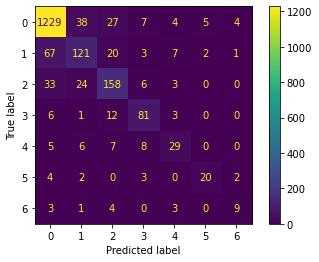

In [44]:
cv_predictionAndLabels = cv_predictions.select("prediction","indexed_dx")
preds_and_probs = cv_predictions.select(['indexed_dx', 'probability', 'prediction'])
cv_metrics = MulticlassMetrics(cv_predictionAndLabels.rdd)
ConfusionMatrixDisplay(cv_metrics.confusionMatrix().toArray().astype(int)).plot()

#### accuracy, precision, recall, fMeasure

In [42]:
print("accuracy: {}".format(cv_metrics.accuracy))
print("precision: {}".format(cv_metrics.weightedPrecision))
print("recall: {}".format(cv_metrics.weightedRecall))
print("fMeasure: {}".format(cv_metrics.weightedFMeasure()))

accuracy: 0.836890243902439
precision: 0.8316500641709982
recall: 0.836890243902439
fMeasure: 0.8336773567560026


### Statistics by class

In [45]:
labels = cv_predictionAndLabels.rdd.map(lambda lp: lp.indexed_dx).distinct().collect()
cv_df = pd.DataFrame()
for label in sorted(labels):
    cv_df = cv_df.append({"class": label, 
               "precision":cv_metrics.precision(label),
               "recall":cv_metrics.recall(label),
               "f1":cv_metrics.fMeasure(label),
              }, ignore_index=True)
cv_df

,class,f1,precision,recall
0,0.0,0.923713,0.912398,0.935312
1,1.0,0.584541,0.626943,0.547511
2,2.0,0.699115,0.692982,0.705357
3,3.0,0.767773,0.750000,0.786408
4,4.0,0.557692,0.591837,0.527273
5,5.0,0.689655,0.740741,0.645161
6,6.0,0.500000,0.562500,0.450000


### ROC

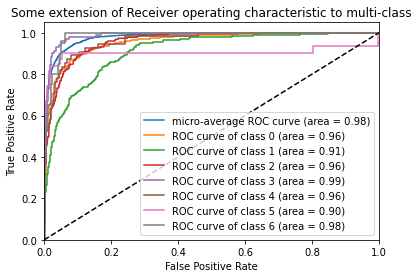

In [46]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

y_test = list(preds_and_probs.select('indexed_dx').toPandas()['indexed_dx'])
y_score = np.array(list(preds_and_probs.select('probability').toPandas()['probability']))
y_test = label_binarize(y_test, classes=[0,1,2,3,4,5,6])
n_classes = y_test.shape[1]


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()